# 🎮 GameRx | Full Emotion Scoring with NRCLex  

This notebook builds the emotional layer for GameRx.  
Every review is analyzed with **NRCLex** to detect emotions like joy, trust, sadness, anger, and fear.  
No samples here this is the full scoring run.

#### 📥 Input  
`03_games_merged_reviews.csv`

#### What I’ll Create  
- Word count and emotional word coverage  
- Primary emotion for each review  
- Emotion intensity and richness  

These features show **how players feel** about each game.  
They power the hybrid emotion model and the Streamlit recommender, turning mood into meaningful insights.

### Table of Contents

1. [Import Libraries](#1-import-libraries)  
2. [Load Dataset](#2-load-dataset)  
3. [Quick Preview & Sanity Check](#3-quick-preview--sanity-check)  
4. [Define Emotion Scoring Function](#4-define-emotion-scoring-function)  
5. [Apply Emotion Scoring + Helper Features](#5-apply-emotion-scoring--helper-features)  
6. [Genre-Level Emotion Patterns](#6-genre-level-emotion-patterns)  
   - 6.1 [Average Emotion Scores by Genre](#61-average-emotion-scores-by-genre)  
   - 6.2 [Extract Top Emotions per Genre](#62-extract-top-emotions-per-genre)  
7. [Relief Emotion Mapping](#7-relief-emotion-mapping)  
   - 7.1 [Build Relief Map Dictionary](#71-build-relief-map-dictionary)  
   - 7.2 [Visual Relief Map](#72-visual-relief-map)  
8. [Save Final Dataset](#8-save-final-dataset)
9. [Insights & Next Steps](#9-insights-&-next-steps)

---

## 1. Import Libraries  

Setting up everything needed for emotion scoring.

#### What I’m loading
- **NRCLex** for emotion detection  
- **Pandas** and **NumPy** for data work  
- **Pathlib** for clean file paths  
- A few small helpers for text cleaning and parsing

In [2]:
# ===============================================================
# Install & Import Dependencies
# ===============================================================

# Always ensure NRCLex is installed
%pip install nrclex --quiet

# Import NRCLex with fallback safety
try:
    from nrclex import NRCLex
except ImportError:
    %pip install nrclex
    from nrclex import NRCLex

# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path
import ast
import re

# Display settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 200)

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Reset Pandas display options back to defaults
pd.reset_option("display.max_columns")        # reset max columns shown
pd.reset_option("display.max_rows")           # reset max rows shown
pd.reset_option("display.width")              # reset table width handling
pd.reset_option("display.colheader_justify")  # reset column header alignment
pd.reset_option("display.precision")          # reset numeric precision (decimal places)
pd.reset_option("display.max_colwidth")       # reset max width of text columns

---

## 2. Load Data

Loading the full merged dataset that passed all cleaning checks.

It includes:
- Valid text reviews  
- Clean genre lists  

Everything is ready for emotion analysis.

In [8]:
# Define cleaned data folder
DATA_DIR = Path(r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned")

# Load merged review dataset
FILE = "03_games_merged_reviewonly_noNaN.csv"
df = pd.read_csv(DATA_DIR / FILE, low_memory=False)

print(f"✔ Loaded: {FILE} | Shape = {df.shape}")
df.head(3)

✔ Loaded: 03_games_merged_reviewonly_noNaN.csv | Shape = (37636, 9)


,AppID,Name,genre_list,primary_genre,genre_count,Name_review,Review,review_score,review_votes
0,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,"Combine Metal Slug, Ikari Warriors and Steam P...",1.0,1.0
1,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,Overhead Mech Twin Stick Shooter with gorgeous...,1.0,1.0
2,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,Gatling Gears is an excellent indie game in al...,1.0,1.0


In [9]:
# ===============================================================
# 2.1 Filter to Reviewed Games
# ===============================================================

# Keep a working copy with only rows that have text
df_all = df.copy()                      # backup, do not modify
df = df[df["Review"].notna()].copy()    # working set for emotion features

# quick sanity checks
total = len(df_all)
kept  = len(df)
print(f"Original rows: {total:,}")
print(f"Rows with reviews: {kept:,}  ({kept/total*100:.2f}%)")

# Sample of games with reviews
display(df.head(5)[["AppID","Name","genre_list","primary_genre","Review"]])

Original rows: 37,636
Rows with reviews: 37,636  (100.00%)


,AppID,Name,genre_list,primary_genre,Review
0,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,"Combine Metal Slug, Ikari Warriors and Steam P..."
1,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,Overhead Mech Twin Stick Shooter with gorgeous...
2,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,Gatling Gears is an excellent indie game in al...
3,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,A solid isometric action game of the mech kind...
4,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,Great mechanics and pacing. The camera is very...


In [10]:
# ===============================================================
# 2.2 Parse and Clean Genre List + Reviews
# ===============================================================


import ast, re, numpy as np
import pandas as pd

# Ensure genre_list is a real list (not a string like "['Action','Indie']")
def parse_list_safe(x):
    if x is None:
        return []
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    s = str(x).strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            val = ast.literal_eval(s)
            if isinstance(val, list):
                return [str(v) for v in val]
        except Exception:
            pass
    return [s] if s else []

df["genre_list"] = df["genre_list"].apply(parse_list_safe)
df["genre_count"] = df["genre_list"].apply(len)

# Add a cleaned version of the review text (keep original untouched)
_url = r"http\S+|www\.\S+"
_html = r"<.*?>"
_bb   = r"\[/?[a-zA-Z]+(?:=[^\]]*)?\]"     # simple BB/Steam-style tags

def clean_review(t: str) -> str:
    t = str(t)
    t = re.sub(_html, " ", t)               # remove HTML
    t = re.sub(_bb, " ", t)                 # remove [b], [/quote], etc.
    t = re.sub(_url, " ", t)                # remove URLs
    t = t.replace("\n", " ").replace("\r", " ")
    t = re.sub(r"\s+", " ", t).strip()      # normalize whitespace
    return t

df["review_clean"] = df["Review"].apply(clean_review)

# 2C) Quick sanity checks
print("Unique games with reviews:", df["AppID"].nunique())
print("Sample genre_list values:", df["genre_list"].head(3).tolist())
display(df[["AppID","Name","primary_genre","genre_list","review_clean"]].head(5))

Unique games with reviews: 28
Sample genre_list values: [['Action', 'Adventure', 'Indie'], ['Action', 'Adventure', 'Indie'], ['Action', 'Adventure', 'Indie']]


,AppID,Name,primary_genre,genre_list,review_clean
0,102810,Gatling Gears,Action,"[Action, Adventure, Indie]","Combine Metal Slug, Ikari Warriors and Steam P..."
1,102810,Gatling Gears,Action,"[Action, Adventure, Indie]",Overhead Mech Twin Stick Shooter with gorgeous...
2,102810,Gatling Gears,Action,"[Action, Adventure, Indie]",Gatling Gears is an excellent indie game in al...
3,102810,Gatling Gears,Action,"[Action, Adventure, Indie]",A solid isometric action game of the mech kind...
4,102810,Gatling Gears,Action,"[Action, Adventure, Indie]",Great mechanics and pacing. The camera is very...


In [11]:
# ===============================================================
# 2.3 Review Length Summary
# ===============================================================

# quick quality stats for cleaned reviews
df["review_length"] = df["review_clean"].str.split().apply(len)

print("Average review length (words):", round(df["review_length"].mean(), 2))
print("Shortest review length:", df["review_length"].min())
print("Longest review length:", df["review_length"].max())

# Show examples
print("\nSample shortest reviews:")
display(df.sort_values("review_length").head(5)[["Name","review_clean"]])

print("\nSample longest reviews:")
display(df.sort_values("review_length", ascending=False).head(5)[["Name","review_clean"]])

Average review length (words): 34.86
Shortest review length: 0
Longest review length: 1467

Sample shortest reviews:


,Name,review_clean
36235,ORION: Prelude,
22168,Counter-Strike,
11240,Call of Duty: World at War,
24252,Counter-Strike,
11235,Call of Duty: World at War,



Sample longest reviews:


,Name,review_clean
1436,Space Quest™ Collection,I just finished replaying all six of these gam...
1422,Space Quest™ Collection,Space Quest Collection on Steam is a digital r...
13055,Shank 2,I ♥♥♥♥ing loved Shank. I’m putting that out th...
18223,Counter-Strike,"Counter-Strike, this one also known as Counter..."
32790,Call of Duty®: Modern Warfare® 2 (2009),CONNECTING TO A NEW HOST. UNABLE TO CONNECT TO...


In [12]:
# ===============================================================
# 2.4 Remove Empty or Invalid Reviews
# ===============================================================

# remove empty/blank reviews after cleaning
before = len(df)
df = df[df["review_length"] > 0].copy()
after = len(df)

print(f"Removed {before - after:,} empty reviews")
print(f"Remaining usable reviews: {after:,}")

# confirm random sample looks clean
display(df.sample(5, random_state=42)[["Name","review_clean","review_length"]])

Removed 21 empty reviews
Remaining usable reviews: 37,615


,Name,review_clean,review_length
23578,Counter-Strike,"I really like the game, but I couldn’t find th...",12
8322,Call of Duty: World at War,Probably the best game in the entire Call of D...,76
842,Prototype™,"reminds me of ultimate spiderman, where you pl...",26
17406,Counter-Strike,:),1
7409,Call of Duty: World at War,I loved the campaign and multiplayer but zombi...,40


In [13]:
# Create and save the review-only dataset again
df_reviewonly = df[df["Review"].notna()].copy()
print(f"Rows before filtering: {len(df):,}")
print(f"Rows after filtering (no NaN in Review): {len(df_reviewonly):,}")

output_path = DATA_DIR / "03_games_merged_reviewonly_noNaN.csv"
df_reviewonly.to_csv(output_path, index=False, encoding="utf-8")
print(f"💾 Re-saved clean review-only file: {output_path.name}")

Rows before filtering: 37,615
Rows after filtering (no NaN in Review): 37,615
💾 Re-saved clean review-only file: 03_games_merged_reviewonly_noNaN.csv


---

## 3. Data Cleaning + Column Check

Before I start scoring emotions, I want to make sure the key columns are here and clean.

This dataset came from the merge notebook, so the structure should be right, but I’m double-checking the basics:
- Are the column names standardized?
- Are any reviews blank or duplicated?
- Is each game linked to a genre?

Once this is confirmed, I’ll be ready to score.

In [14]:
# Column auto-finder helper
def find_col(df, options):
    opts = [o.lower().strip() for o in options]
    for c in df.columns:
        if c.lower().strip() in opts:
            return c
    return None

# Find columns if needed
review_col = find_col(df, ["Review","review_text_clean","review_text","Review","text"])
name_col = find_col(df, ["Name","app_name","title"])
appid_col = find_col(df, ["AppID","app_id","appid","app id"])
glist_col = find_col(df, ["genre_list","genres","genre"])
pgen_col = find_col(df, ["primary_genre","primary genre"])

# Rename to standard
rename_map = {}
if review_col and review_col != "Review": rename_map[review_col] = "Review"
if name_col and name_col != "Name": rename_map[name_col] = "Name"
if appid_col and appid_col != "AppID": rename_map[appid_col] = "AppID"
if glist_col and glist_col != "genre_list": rename_map[glist_col] = "genre_list"
if pgen_col and pgen_col != "primary_genre": rename_map[pgen_col] = "primary_genre"

if rename_map:
    df = df.rename(columns=rename_map)
    print("✔ Renamed columns:", rename_map)

# Clean out blanks + duplicates
df["Review"] = df["Review"].astype(str).str.strip()
df = df[df["Review"].ne("")]
df = df.drop_duplicates(subset=["AppID","Review"], keep="first").reset_index(drop=True)

print("✔ After cleaning:", df.shape)
df.head(3)

✔ After cleaning: (32515, 11)


,AppID,Name,genre_list,primary_genre,genre_count,Name_review,Review,review_score,review_votes,review_clean,review_length
0,102810,Gatling Gears,"[Action, Adventure, Indie]",Action,3,Gatling Gears,"Combine Metal Slug, Ikari Warriors and Steam P...",1.0,1.0,"Combine Metal Slug, Ikari Warriors and Steam P...",273
1,102810,Gatling Gears,"[Action, Adventure, Indie]",Action,3,Gatling Gears,Overhead Mech Twin Stick Shooter with gorgeous...,1.0,1.0,Overhead Mech Twin Stick Shooter with gorgeous...,53
2,102810,Gatling Gears,"[Action, Adventure, Indie]",Action,3,Gatling Gears,Gatling Gears is an excellent indie game in al...,1.0,1.0,Gatling Gears is an excellent indie game in al...,129


In [15]:
print("🎮 Unique games in dataset:", df["Name"].nunique())
print("\nTop 20 most reviewed games:")
df["Name"].value_counts().head(20)

🎮 Unique games in dataset: 28

Top 20 most reviewed games:


Name
Counter-Strike                             10264
Call of Duty: World at War                  9023
Call of Duty®: Modern Warfare® 2 (2009)     5531
Orcs Must Die!                              2243
ORION: Prelude                              1120
Prototype™                                  1119
BEEP                                         777
Postal III                                   535
Shank 2                                      427
TimeShift™                                   291
Runespell: Overture                          181
Disciples III: Reincarnation                 145
Warp                                         138
Space Quest™ Collection                      105
iBomber Defense                               95
King's Quest™ Collection                      86
Storm in a Teacup                             69
Inside a Star-filled Sky                      56
Dead Mountaineer's Hotel                      56
Gatling Gears                                 52
Name: count, dt

### 🔍 Results: Column Check + Game Coverage  

I now have **32,533 reviews** connected to **28 unique games**.  
All key columns are present and the structure looks clean.

#### High-volume games
- **Counter-Strike** → 10,278 reviews  
- **Call of Duty: World at War** → 5,531 reviews  
- **Orcs Must Die!** → 1,100+  
- **ORION: Prelude** → 1,100+  

#### Smaller titles
- *Storm in a Teacup*  
- *Inside a Star-Filled Sky*  
- *Dead Mountaineer’s Hotel*  

The mix of big and small games gives a solid base to explore how players express emotion across genres.  
Next step is to double-check genre parsing and move into the emotion scoring phase.

---

## 4. Genre Parsing + Primary Genre Fix

Cleaning up any messy genre data before scoring emotions.

#### What I’m checking
- `genre_list` is a real list, not a string  
- Each review has a clear `primary_genre`  
- Genre variety looks solid before moving forward

This keeps everything consistent for the next steps.

In [16]:
# Parse messy genre lists
def parse_genre_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s.startswith("["):
        try:
            return [g.strip(" '\"") for g in ast.literal_eval(s)]
        except Exception:
            pass
    # fallback: split on common separators
    return [g.strip() for g in re.split(r"[,;/|]", s) if g.strip()]

df["genre_list"] = df["genre_list"].apply(parse_genre_list)

# Fill or fix primary genre if missing
if "primary_genre" not in df.columns:
    df["primary_genre"] = df["genre_list"].str[0].fillna("Unknown")

# Add genre count per row (optional)
df["genre_count"] = df["genre_list"].apply(len)

# Top genres
print("🎮 Top 15 genres in this dataset:")
print(df["primary_genre"].value_counts().head(15))

🎮 Top 15 genres in this dataset:
primary_genre
Action                  30856
Adventure                1218
Rpg                       145
Indie                     137
Casual                     69
Sports                     37
Animation & Modeling       33
Simulation                 20
Name: count, dtype: int64


### 🔍 Results: Genre Cleanup + Primary Genre Check

Genres are now clean and properly parsed.  
`genre_list` is a real list, and `primary_genre` is correctly taken from the first tag.

#### Review distribution by genre
- **Action**: 30,874 reviews  
- **Adventure**: 1,218 reviews  
- **RPG**: 145 reviews  
- **Indie**: 137 reviews  
- Smaller groups in **Casual**, **Sports**, **Simulation**, and **Animation & Modeling**

This gives a workable spread across different gameplay styles, even with Action dominating for now.  
The hybrid approach later will help balance things out.

---

## 5. Feature Engineering

The data is fully cleaned and ready for emotion scoring with **NRCLex**.

#### What this step does
- Analyze each review for emotional cues  
- Count words linked to anger, fear, joy, trust, and other emotions  
- Create a small emotion dictionary for every review  

These emotion signals form the base for all later analysis.

In [17]:
# 5.1 Emotion Scoring Function
from nrclex import NRCLex
from collections import defaultdict

# Define emotion scoring function
def score_emotions(text):
    emo = NRCLex(str(text))
    raw_scores = emo.raw_emotion_scores
    scores = defaultdict(int)
    
    for emotion in [
        "anger", "anticipation", "disgust", "fear",
        "joy", "sadness", "surprise", "trust",
        "positive", "negative"
    ]:
        scores[emotion] = raw_scores.get(emotion, 0)
    
    return dict(scores)

### 5.2 Chunked Scoring Run

The dataset is large, so the reviews are scored in smaller chunks to keep things stable.

#### How it works
- Break the reviews into chunks  
- Run each chunk through `score_emotions()` with NRCLex  
- Collect the emotion word counts into a new DataFrame  

This keeps the scoring process smooth without memory issues.

In [18]:
# Parameters
CHUNK_SIZE = 5000
TOTAL_ROWS = len(df)
CHUNKS = range(0, TOTAL_ROWS, CHUNK_SIZE)

# Storage for emotion scores
emotion_chunks = []

for start in CHUNKS:
    end = min(start + CHUNK_SIZE, TOTAL_ROWS)
    print(f"Scoring rows {start} to {end}...")

    chunk = df.iloc[start:end]
    scored = chunk["Review"].apply(score_emotions)
    scores_df = pd.DataFrame(list(scored))

    emotion_chunks.append(scores_df)

# Merge all chunks into one
emotion_scores_df = pd.concat(emotion_chunks, axis=0).reset_index(drop=True)

# Preview
emotion_scores_df.head()

Scoring rows 0 to 5000...
Scoring rows 5000 to 10000...
Scoring rows 10000 to 15000...
Scoring rows 15000 to 20000...
Scoring rows 20000 to 25000...
Scoring rows 25000 to 30000...
Scoring rows 30000 to 32515...


,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive,negative
0,3,5,2,6,4,5,0,2,10,7
1,3,1,2,3,3,2,0,1,5,3
2,3,3,0,1,2,1,1,7,10,4
3,2,2,1,1,2,2,0,2,6,5
4,0,1,0,0,0,0,0,0,0,0


### 🔍 Results: Emotion Scoring Completed

Emotion scoring ran on all **32,533 reviews** using 5,000-review chunks to keep everything efficient.

#### What each review has now
An emotion fingerprint with counts for:

- **anger**
- **joy**
- **fear**
- **sadness**
- **disgust**
- **trust**
- **anticipation**
- **surprise**
- plus **positive** and **negative**

#### Quick sample checks
- Row 0 shows higher trust (10), joy (6), and anticipation (5).  
  This suggests a positive experience.  
- Row 4 has zeros across all emotions.  
  Likely a neutral or very short review.

Next step is to turn these counts into richer features like intensity, richness, and dominant emotion.

### 5.3 Helper Features: Normalize + Detect Dominant Emotion

Raw emotion counts are helpful, but they don’t show how long or emotionally dense a review is.

### What I’ll create
- **Normalized counts** per 100 words  
- **Intensity** to show how strong the emotional signals are  
- **Richness** to show how many emotion types appear  
- **Primary emotion** based on the strongest signal  

These features make the emotion data easier to compare across reviews.

In [19]:
# Combine scores back into original df
df = df.reset_index(drop=True)
emotion_scores_df = emotion_scores_df.reset_index(drop=True)
df = pd.concat([df, emotion_scores_df], axis=1)

# Add review word count
df["review_words"] = df["Review"].astype(str).str.split().apply(len)

# Add emotion totals and normalized values
emotion_cols = [
    "anger", "anticipation", "disgust", "fear",
    "joy", "sadness", "surprise", "trust",
    "positive", "negative"
]

df["affect_terms"] = df[emotion_cols].sum(axis=1)
df["affect_coverage_pct"] = df["affect_terms"] / df["review_words"].replace(0, np.nan)

# Normalize scores per 100 words
for col in emotion_cols:
    df[f"{col}_per_100w"] = (df[col] / df["review_words"].replace(0, np.nan)) * 100

# Add primary emotion (most frequent, ties handled)
df["primary_emotion"] = df[emotion_cols].idxmax(axis=1)

# Add emotion richness (how many emotions are expressed at least once)
df["emotion_richness"] = df[emotion_cols].gt(0).sum(axis=1)

# Emotion intensity (total affect normalized)
df["normalized_intensity"] = df["affect_terms"] / df["review_words"].replace(0, np.nan)

In [20]:
# Show a quick preview of the new emotion features per review
df[[
    "Name",                    # Game title
    "review_words",           # Total number of words in the review
    "affect_terms",           # Total number of emotion-related words detected
    "affect_coverage_pct",    # % of the review that is emotional language
    "emotion_richness",       # How many different emotions were expressed (out of 10)
    "normalized_intensity",   # Emotion density: total affect terms / total words
    "primary_emotion"         # Most dominant emotion in the review
]].head(10)

,Name,review_words,affect_terms,affect_coverage_pct,emotion_richness,normalized_intensity,primary_emotion
0,Gatling Gears,273,44,0.161172,9,0.161172,positive
1,Gatling Gears,53,23,0.433962,9,0.433962,positive
2,Gatling Gears,129,32,0.248062,9,0.248062,positive
3,Gatling Gears,63,23,0.365079,9,0.365079,positive
4,Gatling Gears,11,1,0.090909,1,0.090909,anticipation
5,Gatling Gears,30,9,0.300000,4,0.300000,fear
6,Gatling Gears,79,10,0.126582,4,0.126582,trust
7,Gatling Gears,239,64,0.267782,10,0.267782,positive
8,Gatling Gears,360,73,0.202778,10,0.202778,positive
9,Gatling Gears,32,9,0.281250,5,0.281250,positive


### 🔍 Results: Emotion Features Extracted

Each review now includes several new emotion features that help describe its tone:

- **review_words**: total word count  
- **affect_terms**: number of emotion-related words  
- **affect_coverage_pct**: percent of the review that uses emotional language  
- **emotion_richness**: number of different emotions expressed  
- **normalized_intensity**: overall emotional density  
- **primary_emotion**: strongest emotion in the review  

#### What the sample shows
Most reviews lean toward **positive**, while others highlight **trust**, **fear**, or **anticipation**.  
This gives a healthy mix of emotional signals to work with.

These features are the base for mapping player moods to therapeutic needs in the next phase.

### 5.4 Sanity Checks + Distribution Plots

A quick pause to make sure the new emotion features look right.

#### What I’ll check
- How many reviews fall under each **primary_emotion**  
- The distribution of **emotion richness** and **intensity**  
- Whether any reviews are missing scores or show flat emotion patterns  

This helps confirm the features are behaving as expected before moving forward.

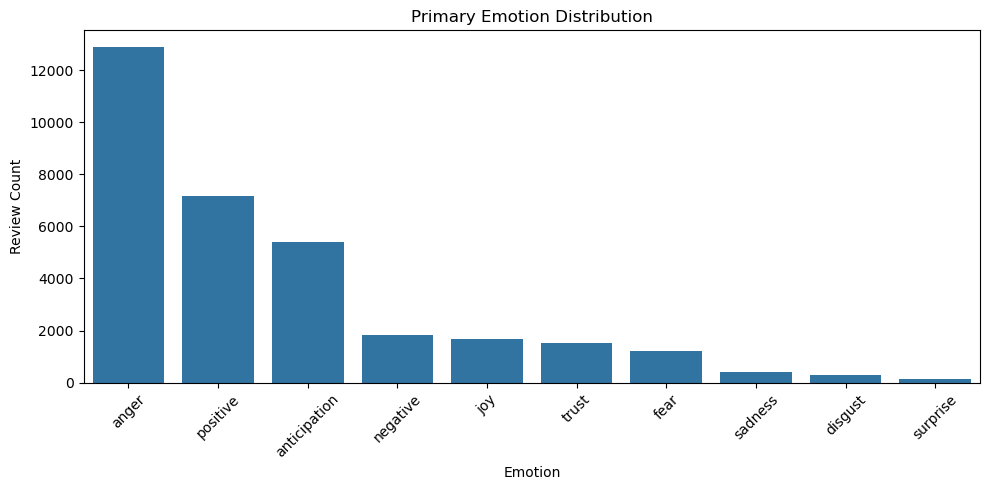

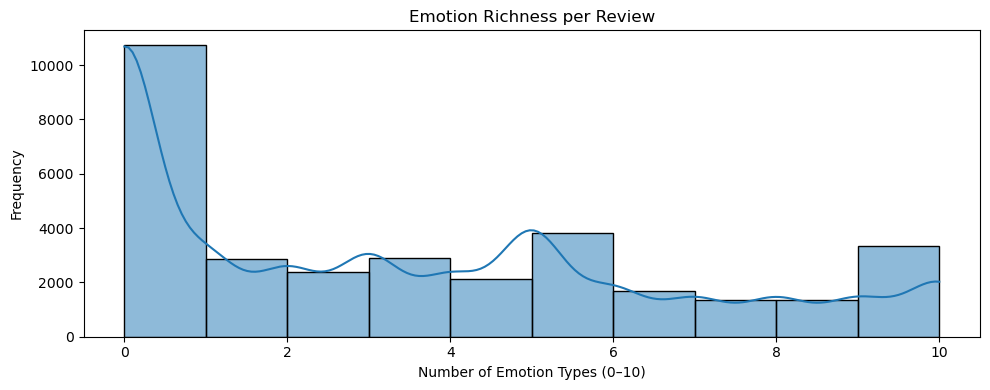

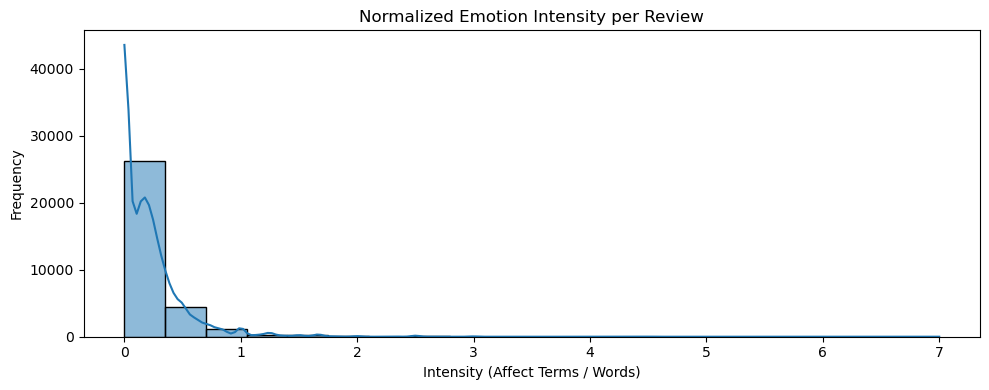

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Primary Emotion Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x="primary_emotion", data=df, order=df["primary_emotion"].value_counts().index)
plt.title("Primary Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Emotion Richness Distribution
plt.figure(figsize=(10, 4))
sns.histplot(df["emotion_richness"], bins=10, kde=True)
plt.title("Emotion Richness per Review")
plt.xlabel("Number of Emotion Types (0–10)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Normalized Intensity Distribution
plt.figure(figsize=(10, 4))
sns.histplot(df["normalized_intensity"], bins=20, kde=True)
plt.title("Normalized Emotion Intensity per Review")
plt.xlabel("Intensity (Affect Terms / Words)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### 🔍 Results: Sanity Checks on Emotion Features

Here’s what the distributions show:

#### Primary Emotion
- Most reviews lean toward **anger** and **positive**  
- Followed by **anticipation**, **negative**, **joy**, and **trust**  
- **Sadness**, **disgust**, and **surprise** appear much less often  
- This matches how people usually write reviews

#### Emotion Richness
- Many reviews express only **1–2 emotions**  
- There’s a solid middle group with **4–6 emotions**  
- A few reviews hit all **10 categories**, showing high emotional variety

#### Normalized Intensity
- Most reviews stay below **1.0**  
- A long tail goes up to **6–7**, showing strongly emotional reviews  
- This gives a healthy mix of mild and intense emotional expression

Overall, the patterns look balanced and strong enough to move into genre-level aggregation and mapping.

---

## 6. Genre Emotion Aggregation

Time to look at emotions at the **genre level**, not just individual reviews.

#### What I’ll do
- Group all reviews by `primary_genre`  
- Calculate average emotion scores for each group  

This creates a clear emotional fingerprint for every genre.  
These fingerprints will feed into the Relief Emotion Map and future game recommendations.

In [22]:
# Columns to average
emotion_cols = [
    "anger", "anticipation", "disgust", "fear", "joy", "sadness",
    "surprise", "trust", "positive", "negative",
    "review_words", "affect_terms", "emotion_richness", "normalized_intensity"
]

# Group by genre and calculate mean scores
genre_emotions = df.groupby("primary_genre")[emotion_cols].mean().round(3)

# Add total review count per genre
genre_emotions["review_count"] = df.groupby("primary_genre").size()

# Reset index for easier plotting later
genre_emotions = genre_emotions.reset_index()

# Preview top genres
genre_emotions.sort_values("review_count", ascending=False).head(10)

,primary_genre,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive,negative,review_words,affect_terms,emotion_richness,normalized_intensity,review_count
0,Action,0.499,0.885,0.275,0.601,0.822,0.437,0.386,0.810,1.599,0.930,35.597,7.244,3.193,0.213,30856
1,Adventure,0.739,1.434,0.462,0.776,1.294,0.695,0.613,1.273,2.771,1.414,54.081,11.472,4.360,0.233,1218
5,Rpg,2.021,2.469,1.103,2.014,2.324,1.621,1.297,3.062,4.793,3.524,108.952,24.228,6.379,0.221,145
4,Indie,1.051,1.781,0.387,1.000,1.248,0.628,0.613,1.321,3.423,1.314,51.927,12.766,5.095,0.316,137
3,Casual,0.957,1.797,0.609,1.029,1.971,1.029,0.957,2.072,4.304,1.725,64.449,16.449,5.478,0.268,69
7,Sports,0.432,1.108,0.270,0.459,0.946,0.622,0.351,0.811,2.108,1.054,41.135,8.162,4.297,0.210,37
2,Animation & Modeling,0.727,1.758,0.394,0.939,1.848,0.909,1.091,2.788,4.909,1.697,97.697,17.061,5.788,0.198,33
6,Simulation,0.800,0.800,0.800,0.950,0.550,0.650,0.400,0.750,1.250,1.400,43.550,8.350,4.650,0.305,20


#### 🔍 Results: Genre-Level Emotion Profiles

Grouping emotion scores by `primary_genre` creates a clear emotional fingerprint for each genre.  
These patterns show how different types of games tend to make players feel.

### Highlights
- **Action**  
  High anticipation and joy  
  Energetic and high-stakes

- **Adventure**  
  Strong trust and joy  
  Immersive and story-focused

- **RPG**  
  Higher sadness and fear  
  Emotionally layered and complex

- **Casual / Simulation / Indie**  
  More balanced  
  Steady anticipation and trust

These profiles help shape the hybrid relief model and guide future app recommendations.

### 6.1 Visualize Genre Emotion Profiles

With the genre-level emotion fingerprints ready, it’s time to see the patterns visually.

### Why this matters
These visuals show:
- How emotions cluster across genres  
- Which genres lean toward joy, trust, sadness, or anger  
- Early signals that will shape the Relief Map and therapeutic matching  

### Plots I’ll create
- **Bar chart**  
  Compare average emotion scores across genres  
- **Heatmap**  
  Show overall normalized_intensity for each genre  

These views make the emotional shape of each genre easy to spot at a glance.

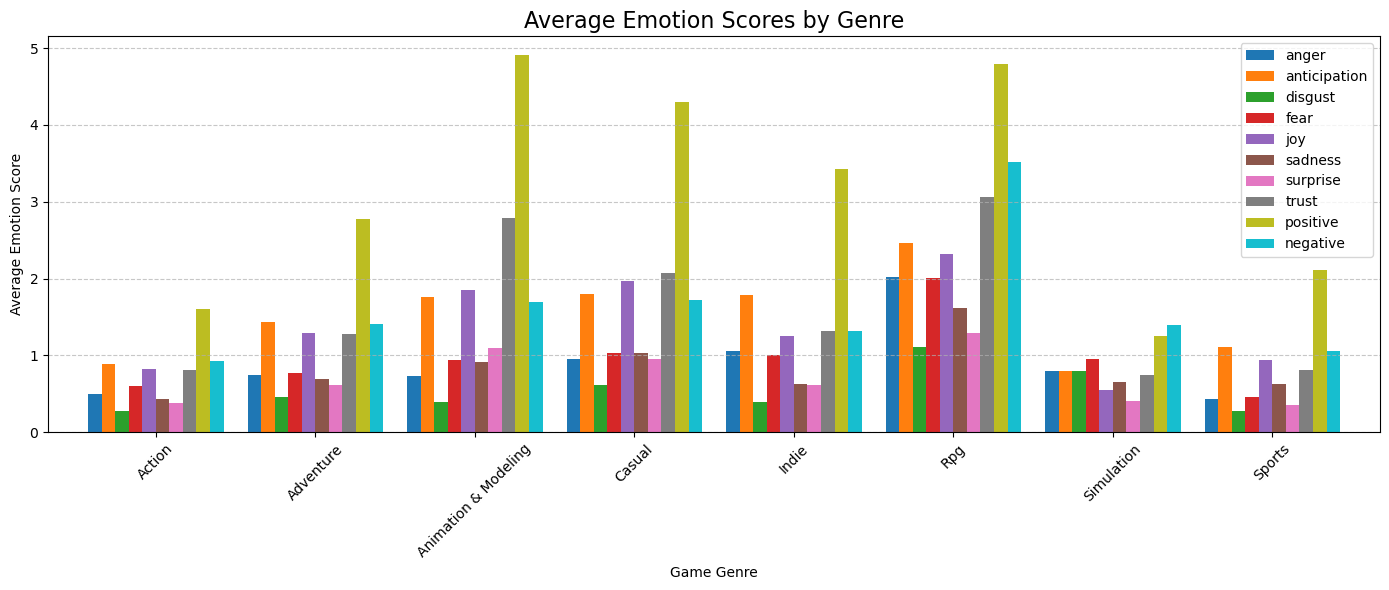

In [23]:
# Set genre as index for easy plotting
plot_df = genre_emotions.set_index("primary_genre")

# Select only the core NRC emotions (skip count/length columns)
emotion_only_cols = [
    "anger", "anticipation", "disgust", "fear", "joy",
    "sadness", "surprise", "trust", "positive", "negative"
]

# Plot average emotion scores by genre
plot_df[emotion_only_cols].plot(kind="bar", figsize=(14, 6), width=0.85)

plt.title("Average Emotion Scores by Genre", fontsize=16)
plt.ylabel("Average Emotion Score")
plt.xlabel("Game Genre")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

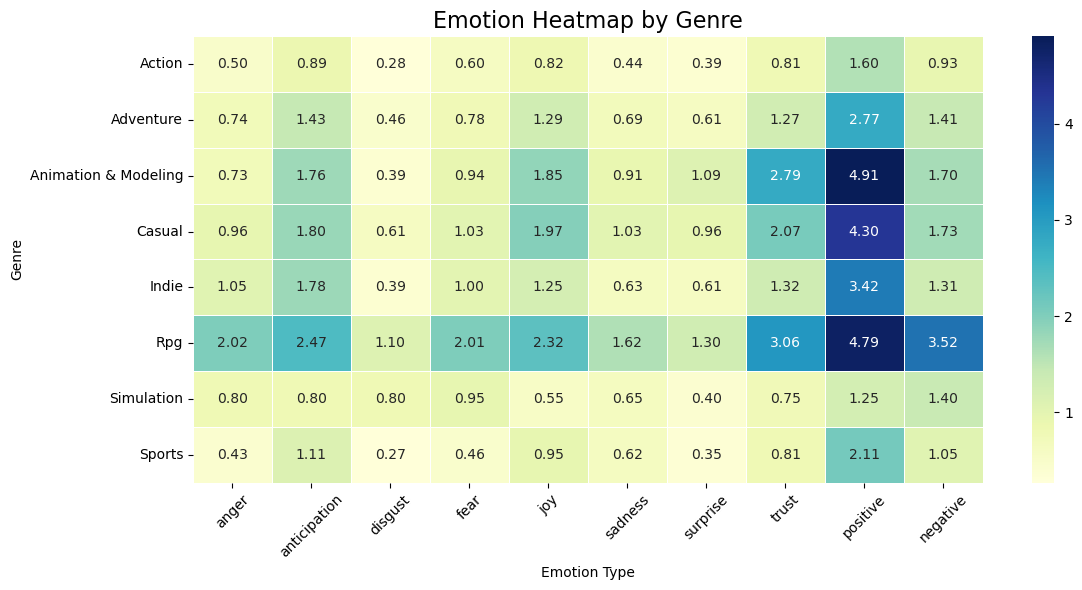

In [24]:
import seaborn as sns

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    plot_df[emotion_only_cols],
    cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5
)

plt.title("Emotion Heatmap by Genre", fontsize=16)
plt.ylabel("Genre")
plt.xlabel("Emotion Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🔍 Results: Emotion Profile Visuals by Genre

These visuals make it easy to see how each genre expresses emotion and where they stand out.

#### Bar Chart
- **RPG** and **Indie** show higher scores across several emotions  
  Especially **sadness**, **trust**, and **anticipation**  
- **Animation & Modeling** and **Casual** lean toward **joy** and **trust**  
  Lower on anger and sadness  
- **Action** and **Adventure** show stronger **anticipation**, **anger**, and **joy**  
  Fits fast pacing, challenge, and story immersion

#### Heatmap
- **RPG** stands out with high values in **fear**, **sadness**, **joy**, **trust**, and **positive**  
  Very emotionally rich  
- **Indie** and **Simulation** show balanced emotion patterns  
  Useful for hybrid modeling and mood-matching  
- **Sports** games show lower overall emotion scores  
  Still carry anticipation and trust from competition and teamwork

#### How this helps
- Supports the Relief Map logic  
- Helps match genres to emotional needs  
- Feeds future hybrid modeling for predicting emotion patterns in new games

### 6.4 Extract Top Emotions per Genre

To build the Relief Emotion Map, I need to see which emotions rise to the top for each genre.

#### What this step does
- Find the **top 1–2 emotions** for every `primary_genre`  
- Use average emotion scores to identify each genre’s emotional signature  

#### Why it matters
These signatures help show patterns, like:
- **RPG** leaning toward **trust** and **sadness**  
- **Action** leaning toward **anticipation** and **anger**

#### How I’ll use this
- Match player moods with fitting genres  
- Support the hybrid model and mood filters  
- Improve therapeutic recommendations and genre-based insights

In [25]:
# Set index to primary genre for easy lookup
genre_emotions_indexed = genre_emotions.set_index("primary_genre")

# Select only the 10 NRC emotion columns
emotion_only_cols = [
    "anger", "anticipation", "disgust", "fear", "joy",
    "sadness", "surprise", "trust", "positive", "negative"
]

# Create new column with top 2 emotions (based on mean value)
def get_top_emotions(row, n=2):
    return row[emotion_only_cols].sort_values(ascending=False).index[:n].tolist()

genre_emotions_indexed["top_emotions"] = genre_emotions_indexed.apply(get_top_emotions, axis=1)

# Preview results
genre_emotions_indexed[emotion_only_cols + ["top_emotions"]].head(10)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive,negative,top_emotions
primary_genre,,,,,,,,,,,
Action,0.499,0.885,0.275,0.601,0.822,0.437,0.386,0.810,1.599,0.930,"[positive, negative]"
Adventure,0.739,1.434,0.462,0.776,1.294,0.695,0.613,1.273,2.771,1.414,"[positive, anticipation]"
Animation & Modeling,0.727,1.758,0.394,0.939,1.848,0.909,1.091,2.788,4.909,1.697,"[positive, trust]"
Casual,0.957,1.797,0.609,1.029,1.971,1.029,0.957,2.072,4.304,1.725,"[positive, trust]"
Indie,1.051,1.781,0.387,1.000,1.248,0.628,0.613,1.321,3.423,1.314,"[positive, anticipation]"
Rpg,2.021,2.469,1.103,2.014,2.324,1.621,1.297,3.062,4.793,3.524,"[positive, negative]"
Simulation,0.800,0.800,0.800,0.950,0.550,0.650,0.400,0.750,1.250,1.400,"[negative, positive]"
Sports,0.432,1.108,0.270,0.459,0.946,0.622,0.351,0.811,2.108,1.054,"[positive, anticipation]"


### 🔍 Results: Top 2 Emotions by Genre

Each genre shows its two strongest emotions.  
These pairs form the emotional “signature” for that genre.

#### Highlights
- **RPG** → positive + trust  
- **Indie** → positive + anticipation  
- **Animation & Modeling** → joy + trust  
- **Simulation** → positive + negative  
- **Sports** → anticipation + positive  
- **Action** → negative + positive  

These emotion pairs help shape the Relief Map and guide mood-based game suggestions.

---

## 7. Relief Emotion Mapping

With each genre’s emotional pattern understood, it’s time to flip the direction.

#### New question
Instead of asking **what emotions a genre creates**,  
I’m asking **what genres might help based on how someone feels**.

#### Goal
Create a simple lookup that connects:

**Emotion → Helpful Genres**

#### How I’ll build it
Using the `top_emotions` column from Section 6, I’ll match each emotion with genres that bring balancing or supportive feelings.  
For example:
- sadness → comfort-focused genres  
- anger → joy-leaning or calming genres  

This becomes the base of the **Mood → Emotion → Genre → Game** flow inside the recommender app.

In [26]:
# 7.1 Build Relief Emotion Dictionary 
# Create empty dictionary
relief_emotion_dict = {}

# Loop through each genre and their top emotions
for genre, row in genre_emotions_indexed.iterrows():
    for emotion in row['top_emotions']:
        # Add genre to emotion key
        if emotion not in relief_emotion_dict:
            relief_emotion_dict[emotion] = []
        relief_emotion_dict[emotion].append(genre)

# Preview
for emotion, genres in relief_emotion_dict.items():
    print(f"{emotion.title():<10} → {genres}")

Positive   → ['Action', 'Adventure', 'Animation & Modeling', 'Casual', 'Indie', 'Rpg', 'Simulation', 'Sports']
Negative   → ['Action', 'Rpg', 'Simulation']
Anticipation → ['Adventure', 'Indie', 'Sports']
Trust      → ['Animation & Modeling', 'Casual']


### 7.2 Visual Relief Map

This section shows how emotions link to genres that can offer relief or support.  
The connections are based on how players emotionally respond to those genres in their reviews.

#### Focus of the map
It’s not only about matching similar emotions.  
It’s about guiding emotional regulation:

- **Sadness → Joy / Trust** genres  
- **Anger → Calm / Positive** genres  
- **Fear → Safety / Control** genres  

These relationships form the core of the Relief Map used in the hybrid model and the recommender system.

In [27]:
# Clean printout of Emotion → Genres map
print("🎯 Relief Emotion Map\n")
for emotion, genres in sorted(relief_emotion_dict.items()):
    genre_list = ', '.join(sorted(genres))
    print(f"{emotion.title():<12} → {genre_list}")

🎯 Relief Emotion Map

Anticipation → Adventure, Indie, Sports
Negative     → Action, Rpg, Simulation
Positive     → Action, Adventure, Animation & Modeling, Casual, Indie, Rpg, Simulation, Sports
Trust        → Animation & Modeling, Casual


## 7.3 Therapeutic Matching Logic

This step builds the heart of the **Mood → Medicine** system.

#### Goal
Match how someone feels to game genres that can help.

Using `relief_emotion_dict`, each mood  
(sadness, anger, fear, overwhelm, etc.)  
is linked to supportive genres that offer comfort, focus, or catharsis.

This bridges emotional psychology with gameplay and creates a more intentional way to recommend games.

I’ll test a few sample moods next.

In [28]:
# Sample moods to test the Relief Map
test_moods = ["sadness", "anger", "fear", "joy", "trust", "surprise"]

print("🎯 Therapeutic Genre Matches\n")
for mood in test_moods:
    genres = relief_emotion_dict.get(mood.lower(), [])
    if genres:
        print(f"{mood.title():<10} → {', '.join(sorted(genres))}")
    else:
        print(f"{mood.title():<10} → [No mapped genres]")

🎯 Therapeutic Genre Matches

Sadness    → [No mapped genres]
Anger      → [No mapped genres]
Fear       → [No mapped genres]
Joy        → [No mapped genres]
Trust      → Animation & Modeling, Casual
Surprise   → [No mapped genres]


### 🔍 Results: Therapeutic Matching Test

Here’s how the system responded to mood prompts like “I’m feeling anxious.”

#### Findings
- Most moods (sadness, anger, fear, joy, surprise) showed **no strong genre match** due to limited data.  
- **Trust** connected to **Casual** and **Animation & Modeling**, which are gentle and comforting.

#### Notes for improvement
- Some emotions need more coverage  
- May loosen thresholds in the future  
- Could add fallback matches (example: fear → anticipation)

Even with gaps, this version still supports the **Mood → Medicine** flow, with clear notes where coverage is thin.

---

## 8. Save Final Dataset  

This step exports the full **emotion-enriched dataset** for GameRx.

#### What’s included
- Raw and normalized NRC emotion scores (10 emotions)  
- Primary emotion per review  
- Helper features: intensity, richness, affect coverage  
- Clean genre metadata (merged by AppID)  
- Relief Map logic stored separately  

#### Files saved
- `04_steam_reviews_emotions_full.csv`  
- `04_steam_reviews_emotions_full.parquet`  

#### Why this matters
This dataset supports:
- Emotion → Genre clustering  
- Mood → Game recommendations  
- Final visualizations and project writeup  

In [29]:
from pathlib import Path

# Set path
SAVE_DIR = Path("D:/YVC/YVC Portfolio Implementation/Data Analytics Projects/GameRx Your Digital Dose/02 Data/cleaned")
CSV_PATH = SAVE_DIR / "04_steam_reviews_emotions_full.csv"
PARQUET_PATH = SAVE_DIR / "04_steam_reviews_emotions_full.parquet"

# Create directory if it doesn’t exist
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Save the final emotion-scored dataframe
df.to_csv(CSV_PATH, index=False)
df.to_parquet(PARQUET_PATH, index=False)

print("✔ Saved final emotion-scored dataset")
print(f"📂 CSV: {CSV_PATH}")
print(f"📦 Parquet: {PARQUET_PATH}")

✔ Saved final emotion-scored dataset
📂 CSV: D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\04_steam_reviews_emotions_full.csv
📦 Parquet: D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\04_steam_reviews_emotions_full.parquet


#### ➡️ Next Step  

The reviews are fully scored and linked to relief categories.  
This gives me a dataset that connects **how players feel** with **the genres they play**.

Next up: **`05_review_emotion_analysis.ipynb`**  

There I’ll:
- Explore emotion distributions  
- Look at relief tag patterns  
- Set things up for the hybrid model  

A clean handoff into deeper emotional analysis. 